In [2]:
# system libraries and path
import os
import sys
import re
import joblib


src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)
data_dir = os.path.join(os.getcwd(), '..', 'data')

# import libraries here; add more as necessary
import numpy as np
import pandas as pd

# pipeline / wrappers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from utils import ClfSwitcher
from imblearn.pipeline import make_pipeline

# preoprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

# cv and model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import roc_auc_score


# plotting
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

# custom modules
from import_module import import_raw_data
import etl
import pipe


Strategy:

- Try different models 
- change preperation (encoding)
- optimize hyperparameters
- add more data

Import data 

In [6]:
mailout_train = import_raw_data('Udacity_MAILOUT_052018_TRAIN.csv',data_dir)
mailout_train.head()


/var/folders/s2/ybtczy7s68qcb8mdvszb6zmm0000gn/T/ipykernel_3153/1309230947.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  mailout_train = import_raw_data('Udacity_MAILOUT_052018_TRAIN.csv',data_dir)


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   8.0                 15.0  ...   
1          NaN          NaN                  13.0                  1.0  ...   
2          NaN          NaN                   7.0                  0.0  ...   
3          NaN          NaN                   6.0                  4.0  ...   
4          NaN          NaN                   9.0                 53.0  ...   

   VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0       5.0         2.0      1.0             6.0             9.0       3.0   
1       1.0         2.0      1.0             4.0             9.0       7.0   
2       6.0         4.0      2.0             NaN             9.0       2.0   
3       8.0        11.0     11.0             6.0             9.0       1.0   
4       2.0         2.0      1.0             6.0             9.0       3.0   

   ZABEOTYP RESPONSE  ANREDE_KZ  ALTERSKATEGORIE_GROB  
0         3        0          2                     4  
1         1        0          2                     3  
2         3        0          1                     4  
3         3        0          2                     4  
4         3        0          1                     3  

[5 rows x 367 columns]

In total the training data has 42962 rows and 367 columns before cleaning

In [7]:
mailout_train.shape 

(42962, 367)

In [8]:
mailout_train = etl.clean_data(mailout_train,data_dir,True)

The data dictionary is imported.
The data dictionary is used to map the missing values.
Attribute PRAEGENDE_JUGENDJAHRE_MAINSTREAM is not available in DataFrame.
Attribute PRAEGENDE_JUGENDJAHRE_YEARS is not available in DataFrame.
Attribute CAMEO_INTL_Economic is not available in DataFrame.
Attribute CAMEO_INTL_Family is not available in DataFrame.
The functions engineer_cameo_intl and engineer_praegende_jj are used to engineer additional variables
The following attributes are dropped because they are not in the data dictionary: []
The following attributes are dropped because they have too many missings or too many levels: ['LNR' 'AGER_TYP' 'ALTER_HH' 'ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3'
 'ALTER_KIND4' 'ALTERSKATEGORIE_FEIN' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015'
 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24'
 'D19_GESAMT_DATUM' 'D19_GESAMT_OFFLINE_D

After cleaning and dropping the data similiar to the segmentation problem there are still 318 variables left

In [9]:
mailout_train.shape 

(42962, 318)

It is a higly imbalaned dataset!

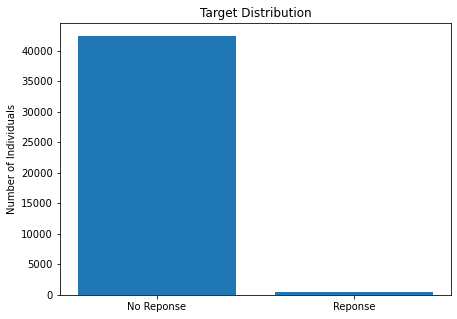

In [10]:
plt.figure(figsize=(7, 5))

response_dist = mailout_train.groupby('RESPONSE').size()
x = response_dist.index.map({0: 'No Reponse',1:'Reponse'})

plt.bar(x,response_dist)
plt.title('Target Distribution')
plt.ylabel('Number of Individuals')

reponse_dist_path = os.path.join(data_dir,'99_plots','target_distribution.png')
plt.savefig(reponse_dist_path,bbox_inches = 'tight')

plt.show()




I am  going to to separate predictors and response column. Furthermore I will separate a holdout set to evaluate the model after tuning it with cross validation. The holdout set is stratified to have enough positive cases

In [13]:
data_dict_path = os.path.join(data_dir,'01_preprocessed/','data_dictionary_full.xlsx')
data_dict = pd.read_excel(data_dict_path, index_col=0)

#mailout_train = mailout_train.sample(frac=1).reset_index(drop=True)

X = mailout_train.drop(columns= 'RESPONSE',axis=1)
y = mailout_train["RESPONSE"].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.15,random_state=42,stratify=y)

At first I am going to use the preprocessing pipeline I used previously in the segmentation task and test it with several boosting algorithms. These boosting algorithms (and random forest) normally perform quite well on this kind of tabular data

In [14]:
# import pipeline already used for unsupervised learning
col_trans = pipe.define_pipeline(data_dict)

# initialize variables and define algorithms which are going to be used 
dfs = []
models = [
      ('rf', RandomForestClassifier(random_state=42)),
      ('ada', AdaBoostClassifier(random_state=42)),
      ('xgb', xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False,random_state=42))
    ]
results = []
names = []
scoring = ['roc_auc']

# intialize stratified kfold 
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# iterate through all models 
for name, model in models:

    model_pipeline = Pipeline([
        ('prep',col_trans),
        ('clf',model)
    ])

    print(name)
    cv_results = cross_validate(model_pipeline,
                                            X_train, 
                                            y_train, 
                                            cv=kfold,
                                            scoring=scoring,
                                            return_train_score=True)   

    # append cv results and name of iteration
    results.append(cv_results)
    names.append(name)

    # create dataframe for this iteration
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name

    # append data.frame of iteration
    dfs.append(this_df)

result_df = pd.concat(dfs, ignore_index=True)



rf
ada
xgb


From the results you can see that the models perform quite bad! The best model has an average roc score of only 0.63. Let's remind ourselves that a random model achieves already score of 0.5! A look at Kaggle results also shows that this is quite bad! 

When comparing the average training validation error with the test score you can clearly see that especially Random forest and Gradient Boosting overfit the data quite strongly (The difference between mean train and mean test score is 0.99 to 0.61 for xgboost

In [17]:
result_df.groupby('model').agg({
    'train_roc_auc' : ['mean', 'std'],
    'test_roc_auc' : ['mean', 'std']
}).round(4)

train_roc_auc         test_roc_auc        
               mean     std         mean     std
model                                           
ada          0.8148  0.0049       0.6323  0.0207
rf           0.9683  0.0040       0.5298  0.0297
xgb          0.9924  0.0009       0.6022  0.0064

As Random Forest performs so bad, I will discard it and continue with the two boosting algorithms. To get a better understanding of what is possible I will use gridsearch to see if other hyperparameters significantly improve the result.
The default parameters for xgboost with max_depth of 6 and a learning rate of 0.3 is quite high. I am going to use parameters which should reduce the overfitting as they make the model less complex

In [20]:
ada_grid = {
    'clf__n_estimators': [50, 100],
    'clf__learning_rate': [0.1, 1.0],
}

xgb_grid = {
    'clf__n_estimators': [50,100],
    'clf__max_depth': [2,3],
    'clf__learning_rate': [0.05,0.15],
}


grids =  {
    'ada': ada_grid,
    'xgb': xgb_grid
}

models = [
      ('ada', AdaBoostClassifier(random_state=42)),
      ('xgb', xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False,random_state=42))
    ]

In [21]:
cv_grid_results = {}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# loop through models
for name,model in models:
    
    # create Pipeline
    model_pipeline = Pipeline([
        ('prep',col_trans),
        ('clf',model)
    ])
    
    # create grid
    grid_search = GridSearchCV(estimator=model_pipeline,
                               param_grid=grids[name],
                               n_jobs=-1, 
                               cv=kfold, 
                               verbose=2,
                               return_train_score=True,
                               scoring='roc_auc')
    
    # fit grid (which also makes predictions) and save results 
    grid_search.fit(X_train,y_train)
    cv_grid_results[name] = grid_search



Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [29]:
cv_grid_results['ada'].best_score_

0.6766744977605855

In [40]:
cv_grid_results['xgb'].best_params_

{'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100}

In [35]:
cv_grid_results['xgb'].cv_results_

{'mean_fit_time': array([ 58.61366097,  77.92566037,  58.62124165, 134.06245907,
         42.35895594,  80.09208433,  56.11525806,  87.24271766]),
 'std_fit_time': array([0.05991544, 6.30829069, 6.77638925, 0.73003275, 8.27074034,
        1.05330959, 5.28501363, 8.04662169]),
 'mean_score_time': array([1.35846543, 2.11681199, 2.52027527, 2.05592243, 2.23214904,
        2.15892935, 2.13867323, 1.2348899 ]),
 'std_score_time': array([0.04256247, 0.05148315, 1.25252188, 0.26582649, 0.08892742,
        0.30334809, 0.20514439, 0.42837368]),
 'param_clf__learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.05, 0.15, 0.15, 0.15, 0.15],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__max_depth': masked_array(data=[2, 2, 3, 3, 2, 2, 3, 3],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__n_estimators': masked

In [30]:
cv_grid_results['xgb'].best_score_

0.6818277112565125

In [36]:
y_test_pred = cv_grid_results['xgb'].best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_test_pred)

0.7223733307148468

In [37]:
cv_grid_results['xgb'].best_params_

{'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100}

Especially Xgboost has improved significantly. As there is more potential I am now going to focus on xgboost. Nevertheless the result is still not too good and there is a lot of room for improvement. There is also a gap between the cross-validatin and the holdout result. 

In the beginning I showed that the data is extremly imbalanced. The positive cases account only for around 1 percent of the data. I will try a sampling method to see whether upsamling the minoriy class can have a positive effect. 

First I am going to try it with creating a relatin of around 1/10

In [41]:
print(y_train.sum() / y_train.shape[0])

from imblearn.over_sampling import RandomOverSampler 
ros = RandomOverSampler(sampling_strategy=1/10,random_state=42)
X_res, y_res = ros.fit_resample(X, y)

print(y_res.sum() / y_res.shape[0])

0.012377796642659583
0.09090909090909091


In [42]:
xgb_mod = xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False,random_state=42)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_grid = {
    'xgbclassifier__n_estimators': [100,150],
    'xgbclassifier__max_depth': [3,4],
    'xgbclassifier__learning_rate': [0.05],
}

# bug as Pipeline and RandomOverSampler dont work together (at least in conda version) 
# https://stackoverflow.com/questions/62489182/trying-to-use-imblearn-pipeline-with-randomoversampler-and-decisiontreeclassifie
# create Pipeline
#model_pipeline = Pipeline([
#    ('prep',col_trans),
#    ('sample', RandomOverSampler(sampling_strategy=1/10,random_state=42)),
#    ('clf',model)
# ])

model_pipeline = make_pipeline(col_trans,ros,xgb_mod)

# create grid
grid_search = GridSearchCV(estimator=model_pipeline,
                           param_grid= xgb_grid,
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=2,
                           return_train_score=True,
                           scoring='roc_auc')





In [43]:
grid_search.fit(X_train,y_train)



Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=99,
                                                                                                        strategy='constant')),
                                                                                         ('one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         array(['AKT_DAT_KL', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP'...
                                                      random_s

In [68]:
grid_search.best_params_

{'xgbclassifier__learning_rate': 0.05,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 100}

In [69]:
grid_search.cv_results_

{'mean_fit_time': array([133.42410477, 194.0529604 , 167.06257097, 189.40137092]),
 'std_fit_time': array([ 0.44349922,  6.12493168, 18.77503625, 10.01399196]),
 'mean_score_time': array([2.11138312, 1.99294623, 2.40530745, 1.13178976]),
 'std_score_time': array([0.21666079, 0.40453681, 0.14290868, 0.38624522]),
 'param_xgbclassifier__learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.05],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbclassifier__max_depth': masked_array(data=[3, 3, 4, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_xgbclassifier__n_estimators': masked_array(data=[100, 150, 100, 150],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'xgbclassifier__learning_rate': 0.05,
   'xgbclassifier__max_depth': 3,
   'xgbclassifier__n_estimators': 100},
  {'xgbclassifier__learning_ra

In [67]:
#y_test_pred2 = grid_search.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_test_pred2)

0.7303819717203456

The sampling has already improved the results!

# Testset 

In [3]:
mailout_test = import_raw_data('Udacity_MAILOUT_052018_TEST.csv',data_dir)



/var/folders/s2/ybtczy7s68qcb8mdvszb6zmm0000gn/T/ipykernel_3673/1909432373.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  mailout_test = import_raw_data('Udacity_MAILOUT_052018_TEST.csv',data_dir)


In [4]:
mailout_test.shape

(42833, 366)

In [56]:
mailout_test = import_raw_data('Udacity_MAILOUT_052018_TEST.csv',data_dir)
mailout_test_cleaned = etl.clean_data(mailout_test,data_dir)
mailout_test_preds = model_pipeline.predict_proba(mailout_test_cleaned)[:,1]

/var/folders/s2/ybtczy7s68qcb8mdvszb6zmm0000gn/T/ipykernel_3153/2710037532.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  mailout_test = import_raw_data('Udacity_MAILOUT_052018_TEST.csv',data_dir)


The data dictionary is imported.
The data dictionary is used to map the missing values.
Attribute PRAEGENDE_JUGENDJAHRE_MAINSTREAM is not available in DataFrame.
Attribute PRAEGENDE_JUGENDJAHRE_YEARS is not available in DataFrame.
Attribute CAMEO_INTL_Economic is not available in DataFrame.
Attribute CAMEO_INTL_Family is not available in DataFrame.
The functions engineer_cameo_intl and engineer_praegende_jj are used to engineer additional variables
The following attributes are dropped because they are not in the data dictionary: []
The following attributes are dropped because they have too many missings or too many levels: ['LNR' 'AGER_TYP' 'ALTER_HH' 'ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3'
 'ALTER_KIND4' 'ALTERSKATEGORIE_FEIN' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015'
 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24'
 'D19_GESAMT_DATUM' 'D19_GESAMT_OFFLINE_D

In [57]:
test_result_df = pd.DataFrame({
  'LNR': mailout_test['LNR'],
  'RESPONSE': mailout_test_preds
}
)

In [58]:
test_result_path = os.path.join(data_dir,'02_models/','kaggle_output_test_new.csv')
test_result_df.to_csv(test_result_path,index=False)